<a href="https://colab.research.google.com/github/atmarachchige0081/ESP32-S3-TFlite-using-ESP-IDF/blob/main/lstm%2Bcnn%20Hybrid%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# 1D CNN Model
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input

data = pd.read_csv('/content/output.csv')

X = data['Differential Value'].values.reshape(-1, 1, 1)
y = data['Label'].values
y = to_categorical(y)

scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, 1)).reshape(-1, 1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

def create_model():
    model = Sequential([
        Input(shape=(1, 1)),  # Update input shape here
        Conv1D(filters=16, kernel_size=1, activation='relu'),  # Adjust kernel size if needed
        GlobalAveragePooling1D(),
        Dense(y.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=10, verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.2f}')

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)
print(tf.math.confusion_matrix(y_true, y_pred))


Epoch 1/50
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9663 - loss: 0.2151 - val_accuracy: 0.9768 - val_loss: 0.1080
Epoch 2/50
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9756 - loss: 0.1106 - val_accuracy: 0.9770 - val_loss: 0.1028
Epoch 3/50
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9746 - loss: 0.1100 - val_accuracy: 0.9772 - val_loss: 0.1003
Epoch 4/50
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9760 - loss: 0.1052 - val_accuracy: 0.9774 - val_loss: 0.0995
Epoch 5/50
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9746 - loss: 0.1095 - val_accuracy: 0.9774 - val_loss: 0.0991
Epoch 6/50
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9735 - loss: 0.1144 - val_accuracy: 0.9774 - val_loss: 0.0996
Epoch 7/50
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9729 - loss: 0.1110 - val_accuracy: 0.9774 - val_loss: 0.0991
Epoch 8/50
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9733 - loss: 0.1161 

294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


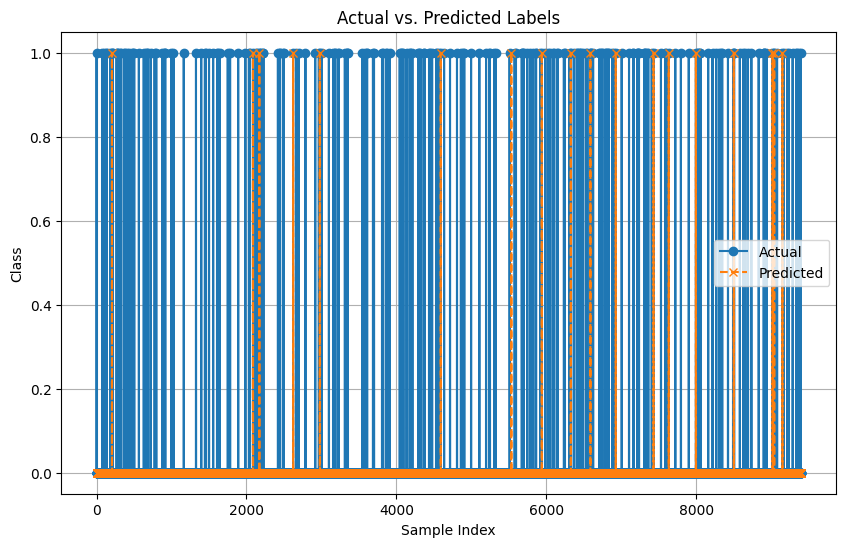

In [11]:
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual', marker='o')
plt.plot(y_pred_classes, label='Predicted', marker='x', linestyle='--')
plt.title('Actual vs. Predicted Labels')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load data
data = pd.read_csv('/content/output.csv')

# Function to create sequences
def create_sequences(data, sequence_length=250):
    X, y = [], []
    for i in range(0, len(data) - sequence_length + 1, sequence_length):
        X.append(data.iloc[i:i + sequence_length]['Differential Value'].values.reshape(-1, 1))
        y.append(data.iloc[i + sequence_length - 1]['Label'])
    return np.array(X), np.array(y)

# Prepare the dataset
X, y = create_sequences(data)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(250, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(100),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Setup early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with increased batch size and more validation data
history = model.fit(X_train, y_train, epochs=8, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
evaluation = model.evaluate(X_test, y_test)

# Print evaluation results
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

# Save the model
model.save('cnn_lstm_model.h5')


Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 476ms/step - accuracy: 0.8545 - loss: 0.6515 - val_accuracy: 0.9667 - val_loss: 0.5548
Epoch 2/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9674 - loss: 0.5423 - val_accuracy: 0.9667 - val_loss: 0.4340
Epoch 3/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9622 - loss: 0.4254 - val_accuracy: 0.9667 - val_loss: 0.3032
Epoch 4/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9622 - loss: 0.3125 - val_accuracy: 0.9667 - val_loss: 0.1925
Epoch 5/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9622 - loss: 0.2063 - val_accuracy: 0.9667 - val_loss: 0.1462
Epoch 6/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9674 - loss: 0.1647 - val_accuracy: 0.9667 - val_loss: 0.1459
Epoch 7/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9726 - loss: 0.1170 - val_accuracy: 0.9667 - val_loss: 0.1588
Epoch 8/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9622 - loss: 0.1442 - val_accuracy: 0.9667 - val_loss: 0.1688
2/2 ━━━━━━━━━━━━━

Test Loss: 0.02268667332828045, Test Accuracy: 1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


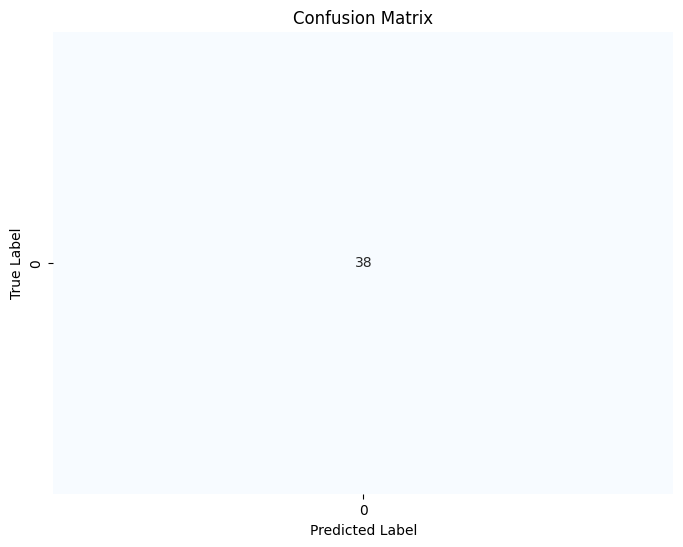

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


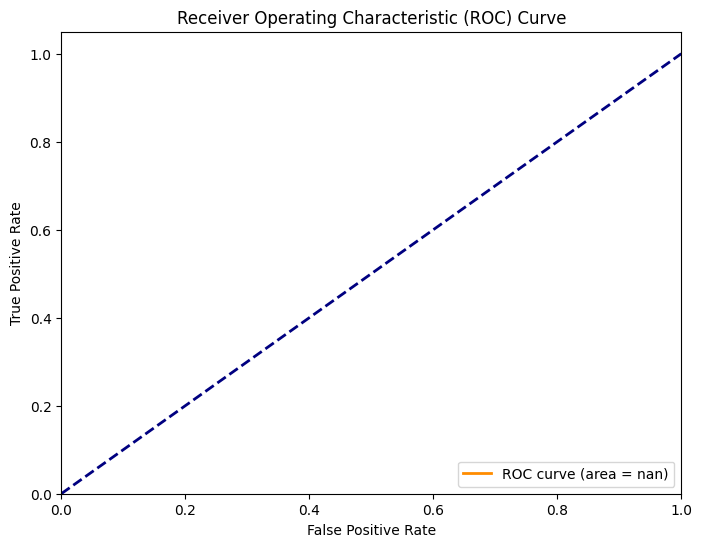

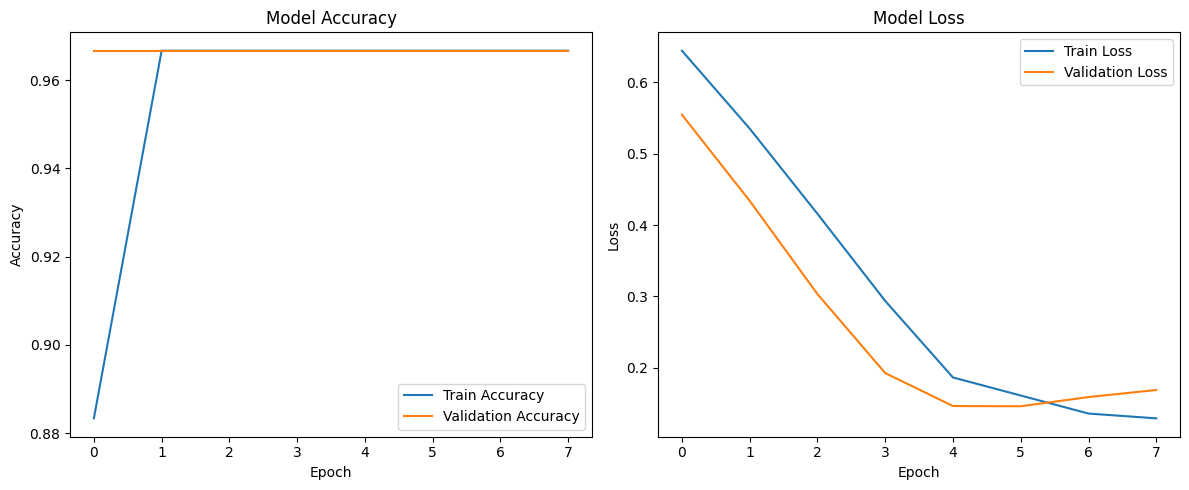

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('cnn_lstm_model.h5')

# Generate predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy and Loss Over Epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Use CNNs alone when:

The primary task involves spatial feature recognition which doesn't necessarily depend on the order of data points. For example, identifying the presence of a particular feature within a time window.
Computational efficiency is a priority, and the temporal dependencies are either not critical or are relatively short-term, which can be effectively covered by the convolutional kernel size.

# Use LSTMs alone when:

The problem requires understanding long-term dependencies in data, such as predicting future steps in a time series where past information is crucial.
The sequence's context significantly impacts your predictions.

# Use CNNs combined with LSTMs when:

Both local features and their temporal evolution are important. For example, in audio processing, a CNN might detect specific sounds, while an LSTM might track how these sounds evolve over time to understand speech.
Enhancing model performance by initially reducing dimensionality and complexity with CNNs, then capturing sequence dynamics with LSTMs.

In [ ]:
## Feature Engineering
Statistical Features:
Adding features like rolling averages,
standard deviations, or peak detection metrics over sliding windows can provide additional context to the model.

In [19]:
pip install keras-tcn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [24]:
!pip install --upgrade tensorflow
!pip install --upgrade keras-tcn
